## Loading data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, pickle
import anndata as ad
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set scanpy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_header()

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.2.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()


... reading from cache file cache/filtered_gene_bc_matrices-matrix.h5ad


## Basic filtering

In [3]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)


filtered out 54 cells that have less than 100 genes expressed
filtered out 13118 genes that are detected in less than 2 cells


In [4]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
casp_genes = [name for name in adata.var_names if name.startswith('Casp')]

# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_casp'] = np.sum(adata[:, casp_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell & fraction mitochondrial as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata.shape

(5429, 19167)

normalizing counts per cell
    finished (0:00:00)


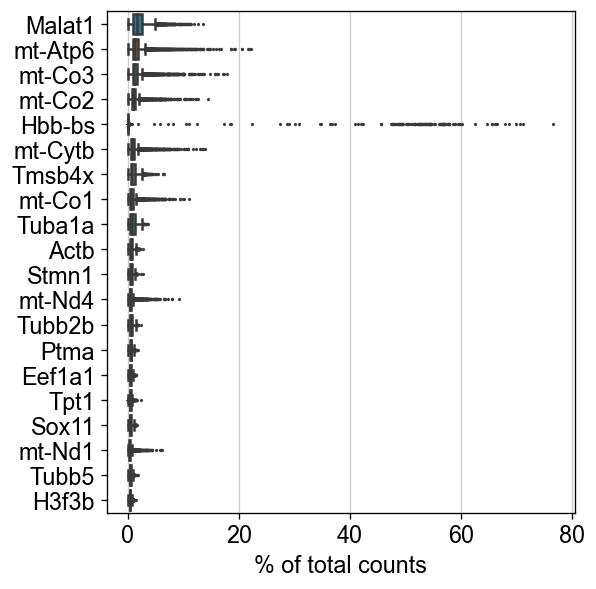

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

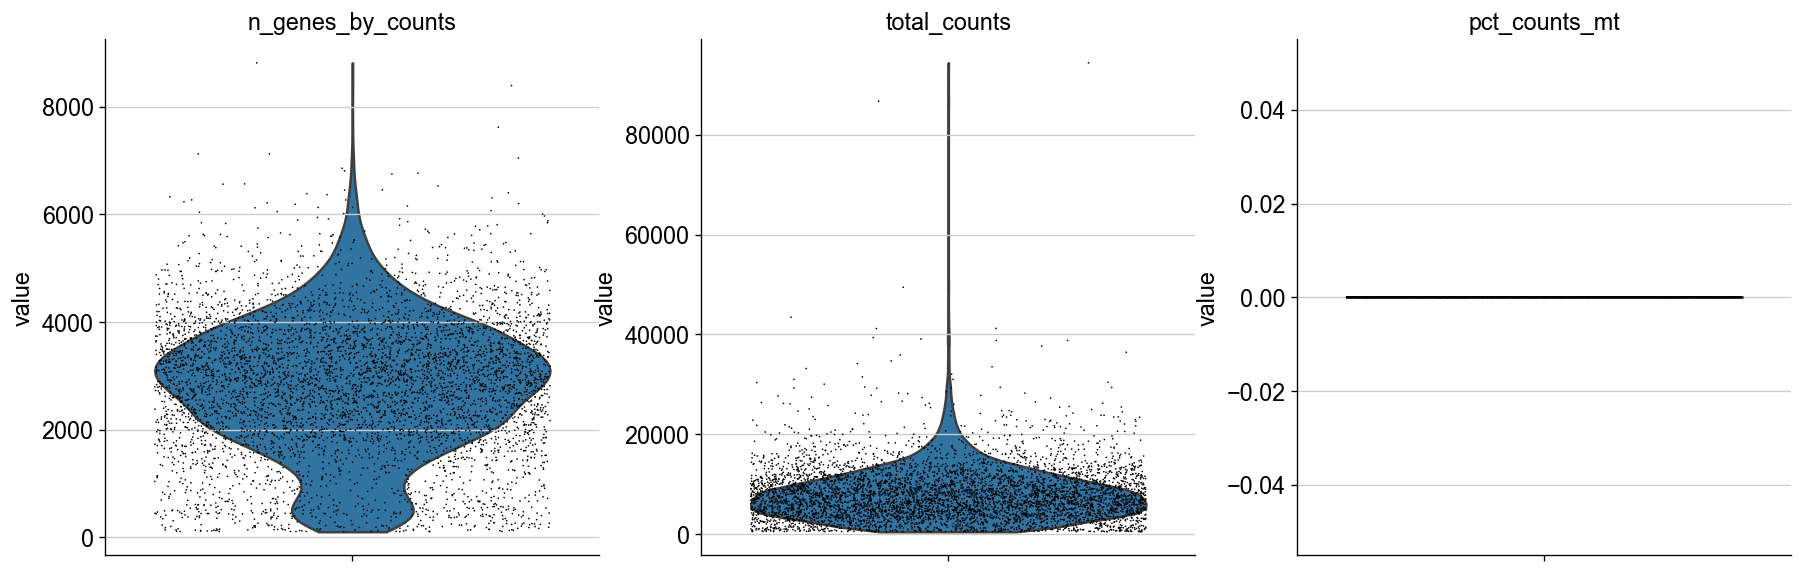

In [7]:
#results: we don't have mtDNA in our set
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

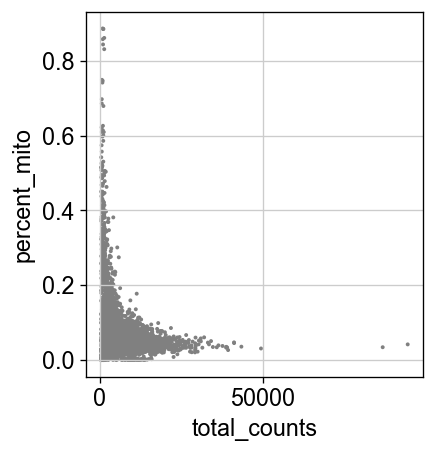

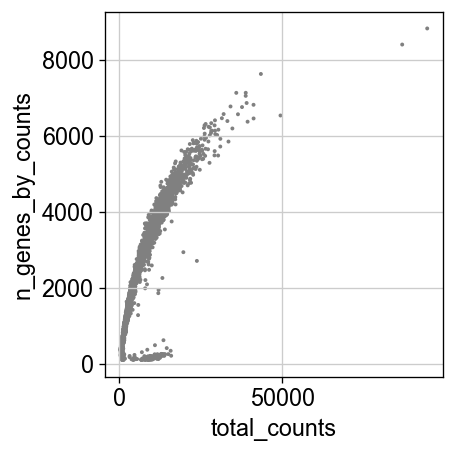

In [8]:

sc.pl.scatter(adata, x='total_counts', y='percent_mito', save = '_mito.pdf')

#our n_genes_by_counts are actually sliced pretty well already
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', save = '_counts.pdf')



In [9]:
# Remove cells that have too many genes or too much mitochondrial
adata = adata[adata.obs['n_genes'] < 6000, :] 
adata = adata[adata.obs['percent_mito'] < 0.06, :] 
adata = adata[adata.obs['percent_casp'] < 0.001, :] 

In [10]:
adata.shape

(3109, 19167)

/Users/JacksonSmith/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


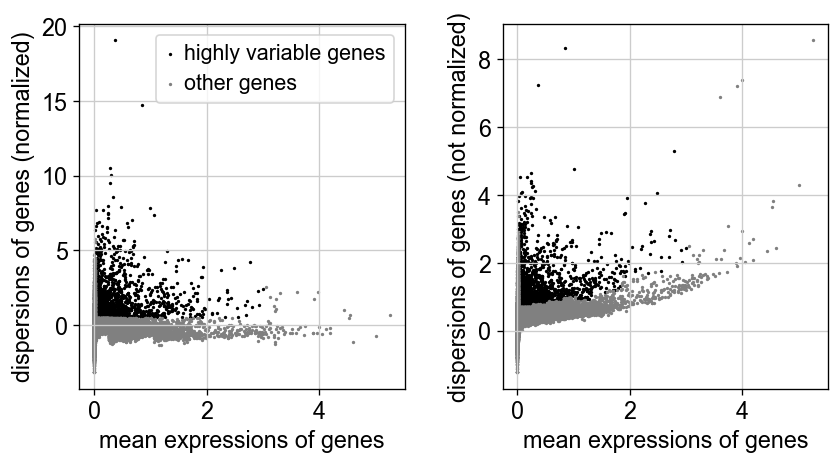

In [11]:
#normalizing and log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
#slice out everything except the highly variable/interesting data
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

#regress out unwanted obs and scale within 10 std dev
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=8)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:14)


In [13]:
adata.shape

(3109, 2738)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


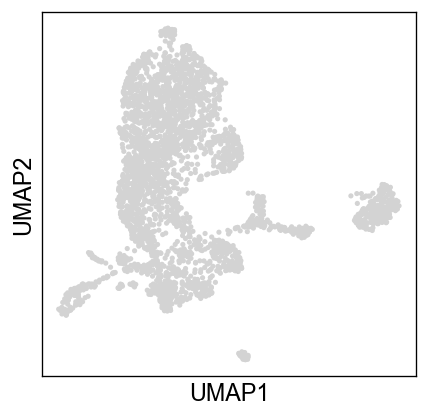

In [14]:
#compute neighbor graph for clustering and embed

#trying different neighboorhood radii until happy with UMAP graph
sc.pp.neighbors(adata, n_neighbors = 50)
sc.tl.umap(adata)

#plot our umap (will cluster with leiden algorithm as in tutorial)
sc.pl.umap(adata, use_raw=False, save = '_unclustered.pdf')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


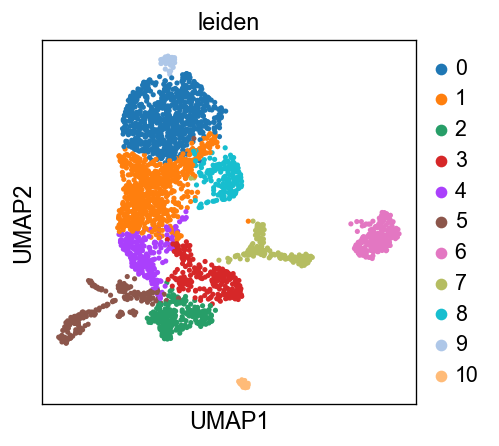

In [15]:
sc.tl.leiden(adata, resolution = 0.5)

sc.pl.umap(adata, color=['leiden'], save = '_unlabled.pdf')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


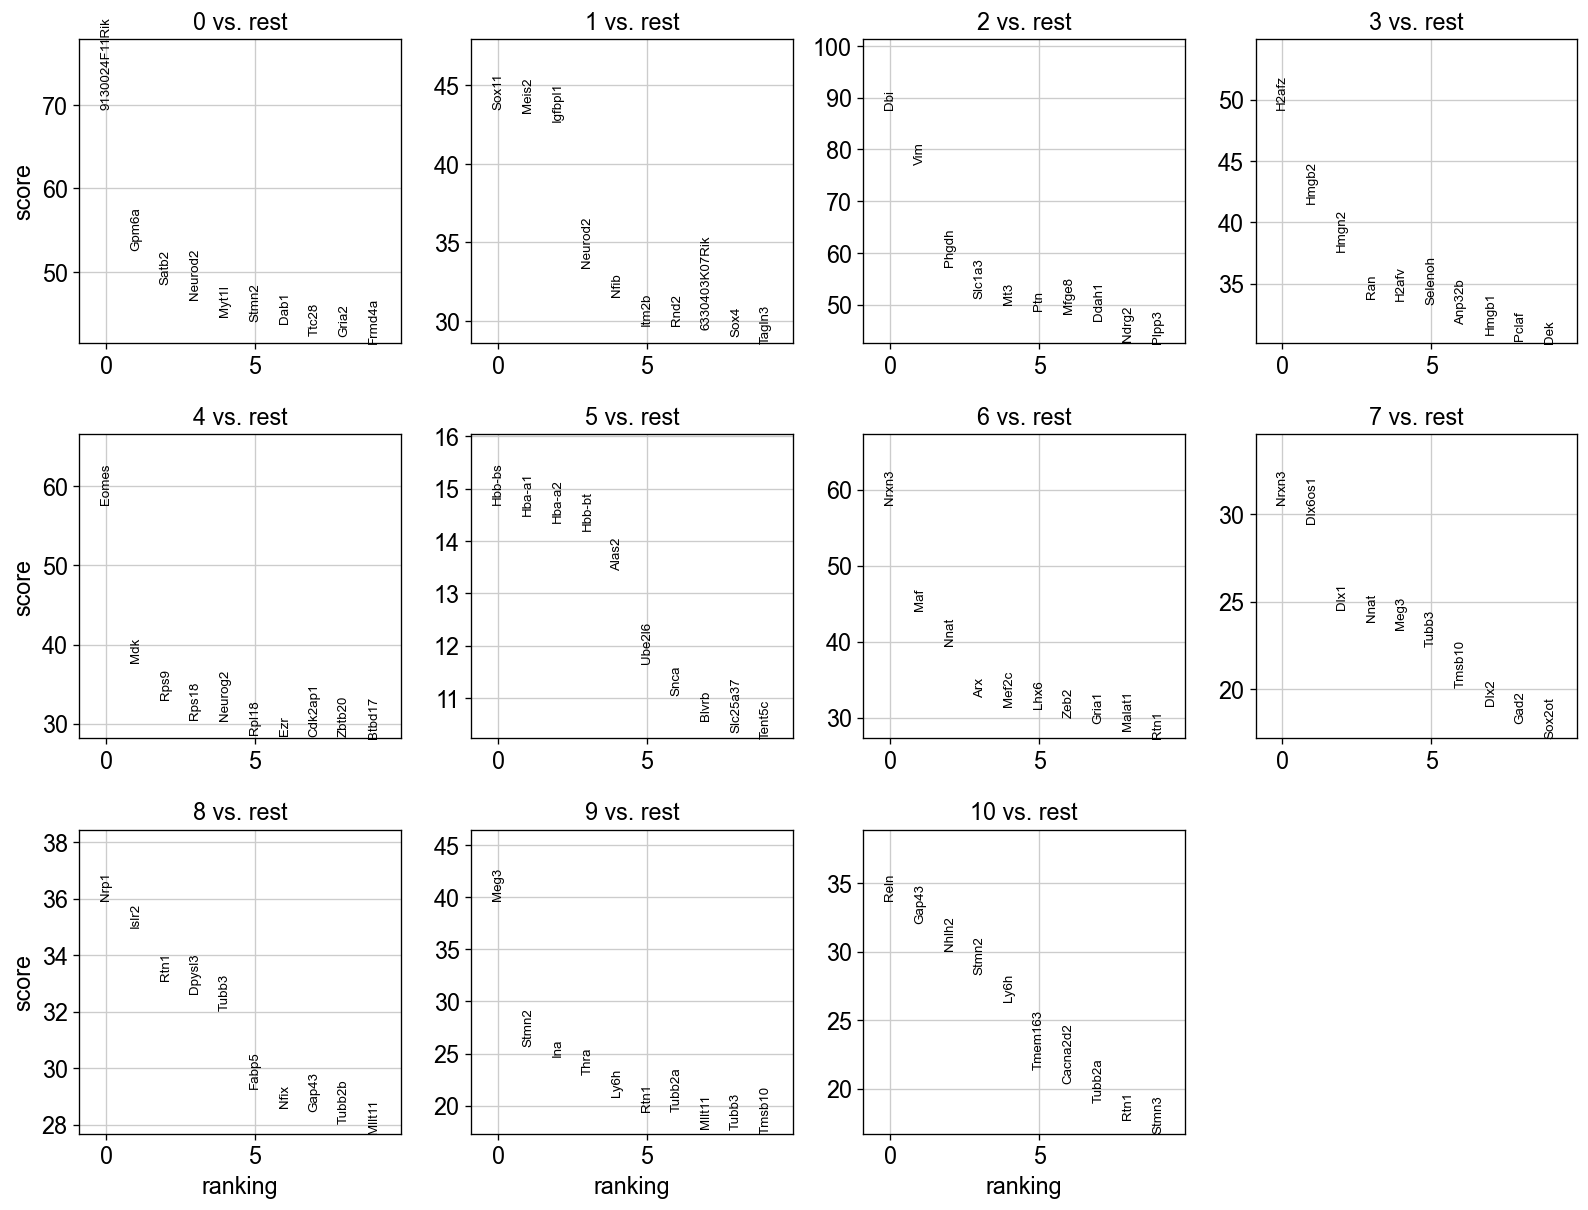

In [16]:
#using t-test to find marker candidate genes for clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [17]:
#top 5 marker genes per cluster via t-test method
ttest = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

ttest

,0,1,2,3,4,5,6,7,8,9,10
0,9130024F11Rik,Sox11,Dbi,H2afz,Eomes,Hbb-bs,Nrxn3,Nrxn3,Nrp1,Meg3,Reln
1,Gpm6a,Meis2,Vim,Hmgb2,Mdk,Hba-a1,Maf,Dlx6os1,Islr2,Stmn2,Gap43
2,Satb2,Igfbpl1,Phgdh,Hmgn2,Rps9,Hba-a2,Nnat,Dlx1,Rtn1,Ina,Nhlh2
3,Neurod2,Neurod2,Slc1a3,Ran,Rps18,Hbb-bt,Arx,Nnat,Dpysl3,Thra,Stmn2
4,Myt1l,Nfib,Mt3,H2afv,Neurog2,Alas2,Mef2c,Meg3,Tubb3,Ly6h,Ly6h


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


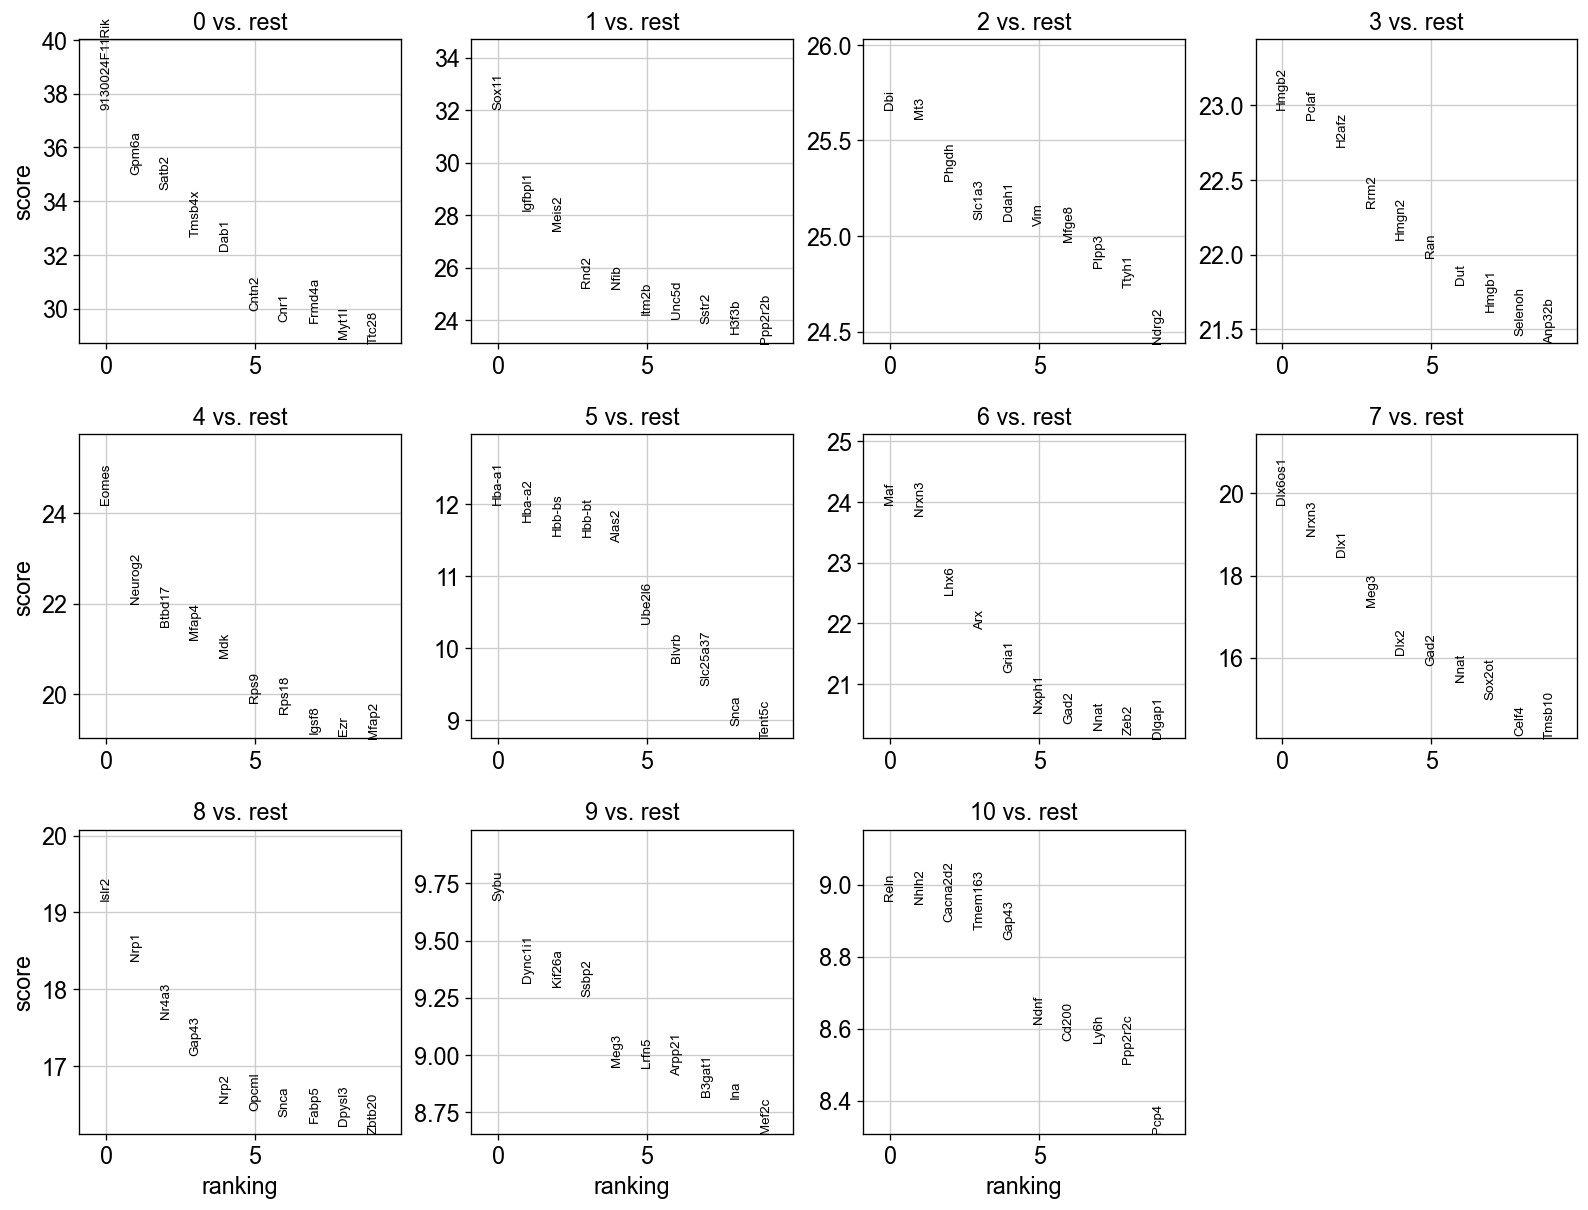

In [18]:
#using wilcoxon method to find candidate marker genes for clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [19]:
#top marker genes per cluster via wilcoxon method
wilcoxon = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

wilcoxon

,0,1,2,3,4,5,6,7,8,9,10
0,9130024F11Rik,Sox11,Dbi,Hmgb2,Eomes,Hba-a1,Maf,Dlx6os1,Islr2,Sybu,Reln
1,Gpm6a,Igfbpl1,Mt3,Pclaf,Neurog2,Hba-a2,Nrxn3,Nrxn3,Nrp1,Dync1i1,Nhlh2
2,Satb2,Meis2,Phgdh,H2afz,Btbd17,Hbb-bs,Lhx6,Dlx1,Nr4a3,Kif26a,Cacna2d2
3,Tmsb4x,Rnd2,Slc1a3,Rrm2,Mfap4,Hbb-bt,Arx,Meg3,Gap43,Ssbp2,Tmem163
4,Dab1,Nfib,Ddah1,Hmgn2,Mdk,Alas2,Gria1,Dlx2,Nrp2,Meg3,Gap43


In [20]:

marker_genes = []

#Find the set of top marker genes in clusters
#from the two testing methods performed

for list in (wilcoxon[:1].values.tolist() + ttest[:1].values.tolist()):
    for gene in list:
        if gene not in marker_genes:
            marker_genes.append(gene)
            
marker_genes

['9130024F11Rik',
 'Sox11',
 'Dbi',
 'Hmgb2',
 'Eomes',
 'Hba-a1',
 'Maf',
 'Dlx6os1',
 'Islr2',
 'Sybu',
 'Reln',
 'H2afz',
 'Hbb-bs',
 'Nrxn3',
 'Nrp1',
 'Meg3']

In [21]:
#table with scores and groups of genes
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

#not sure about having p score 0 for first several cluster marker gene candidates
GenesPVals = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(4)

GenesPVals

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p
0,9130024F11Rik,2.115599e-306,Sox11,4.068106e-225,Dbi,3.105454e-145,Hmgb2,8.559004e-117,Eomes,3.169352e-129,...,Maf,7.838537e-127,Dlx6os1,1.303015e-86,Islr2,7.457806e-82,Sybu,3.720728e-22,Reln,3.309606e-19
1,Gpm6a,2.559232e-268,Igfbpl1,5.918011e-175,Mt3,9.649220e-145,Pclaf,3.748301e-116,Neurog2,2.610908e-107,...,Nrxn3,4.535295e-125,Nrxn3,2.216031e-80,Nrp1,1.880842e-75,Dync1i1,1.180534e-20,Nhlh2,3.606331e-19
2,Satb2,9.729033e-260,Meis2,1.064374e-165,Phgdh,4.064451e-141,H2afz,2.603060e-114,Btbd17,1.755610e-102,...,Lhx6,6.235052e-112,Dlx1,4.092888e-76,Nr4a3,1.778324e-69,Kif26a,1.412409e-20,Cacna2d2,5.718160e-19
3,Tmsb4x,2.205424e-234,Rnd2,7.383620e-141,Slc1a3,7.117131e-139,Rrm2,2.302402e-110,Mfap4,5.740087e-100,...,Arx,2.245438e-106,Meg3,1.325470e-66,Gap43,8.357022e-66,Ssbp2,2.143279e-20,Tmem163,6.980885e-19


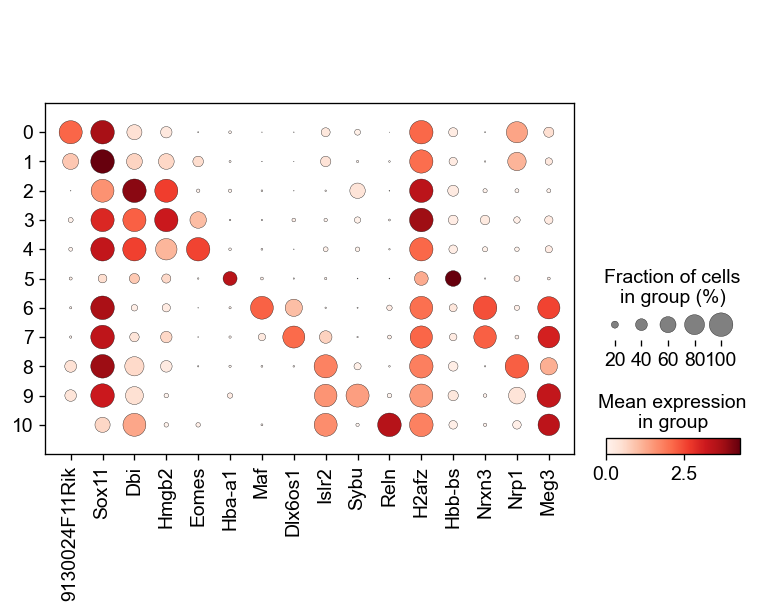

In [22]:
#plot expression of different marker genes within clusters
#Can try to identify cell type candidates from these data
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
sc.pl.dotplot(adata, marker_genes, groupby='leiden', save = 'Unlabled›.pdf');

Now we want to map each cluster to what type of cell it is. We can do so by knowing that this RNA seq data is taken from a mouse hippocampus, searching through literature for a match with the marker gene expression profiles:

Note that Sox11, Uchl1, Igfbpl1, H2afz, Basp1 are expressed mostly throughout our sample and are considered less interesting. 

Cluster 0 is likely an Excitatory Neuron based off of its elevated 9130024F11Rik expression level. (jneurosci.org/content/jneuro/28/1/264.full.pdf)

Cluster 1 and 8, based on the high levels of Igfbpl1 and presence of Nrp1 expression, are most likely epithelial cells. (https://www.nature.com/articles/labinvest201466#:~:text=Nrp1%20is%20expressed%20in%20normal,squamous%20cell%20carcinoma%20(SCC).)

Cluster 2 shows high expression levels of Dbi and H2afz as marker genes, which have extremely low specificty, and therefore the identity of cluster 2 is left as "Udtd," for undetermined without more data.

Clusters 3 and 4 has notable Eomes expression, and is almost certainly a CD8 T Cell (https://www.nature.com/articles/s42003-019-0389-3#:~:text=Eomesodermin%20(Eomes)%20is%20a%20T,memory%20CD8%2B%20T%20cells9.)

Cluster 5 has high density of hemogolbin-related gene expression, and is most likely an erythrocytes (red blood cell)

Cluster 6 most notable has high Maf and Nrxn3 expression, and is likely an interneuron (https://www.nature.com/articles/srep45656)

Cluster 7, with high Dlx6os1 and Nrxn3 expression, is likely a mesanchymal cell (http://www.informatics.jax.org/marker/MGI:2443217)

Cluster 9 is likely a Glial cell as a result of its relative increase in Sybu expression (https://www.proteinatlas.org/ENSG00000147642-SYBU/celltype)

Cluster 10 demonstrates elevated Reln expression and is highly likely to be an Stellate cell

In [23]:
#create list of proposed cell types for mapping onto leiden and dot plots
cell_types = ['Excitatory Neuron','Epithethelial-1','Undetermined', 'CD8 T-1', 'CD8 T-2','Erythrocyte','Interneuron','Mesanchymal', 'Epithelial-2','Glial','Stellate']

adata.rename_categories('leiden', cell_types)

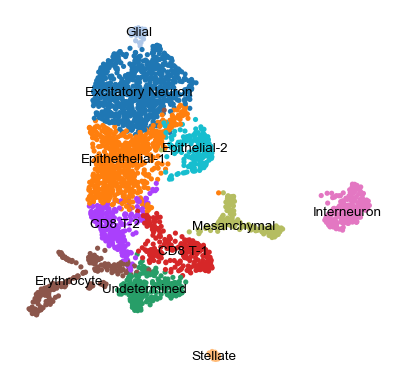

In [24]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', legend_fontweight='light', legend_fontsize='xx-small', frameon=False, save='.pdf')

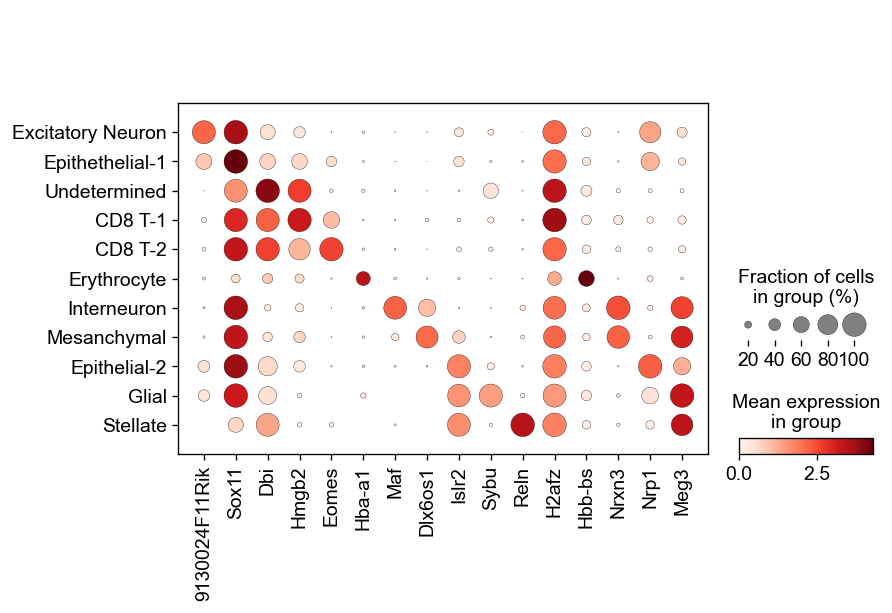

In [25]:
#Dotplot with proposed cell typings and their gene expression
sc.pl.dotplot(adata, marker_genes, groupby='leiden', save = '.pdf');